# 1. 단순 모델
    - 무료 학생들의 기록 <-> 유료 학생들의 무료 시기의 기록
    - 두개의 유사도가 같으면 무료 -> 유료로 전환할 가능성 높다고 판단
    1. 무료 - 유료 기준
        - 유료 : 한 번이라도 구매를 한 학생
        - 무료 : 단 한번도 구매하지 않은 학생
        * 단 유료 학생들의 무료 시기는 첫 구매 전까지만 포함
    2. 사용 feature
        - num_course : 한번이라도 수강한 코스 종류 수
        - sum_watched : 수강한 코스들 총 수강시간
        - eng_quizzes : 참가한 퀴즈 횟수
        - eng_lessons : 강의 수강 횟수
        - eng_exam : 참가한 시험 횟수
        - num_engagement : 퀴즈-강의-시험을 실행한 날짜 수
        - num_exam : 시험 종류
    3. Process
        - 가공한 feature를 PCA를 통해 2개의 컬럼으로 압축
        - 이 중 유료 학생를 만 추출하여 BayesianGaussianMixtue Model 적용 -> 데이터들의 mean, covariance 계산
        - stats.multivariate_normal으로 해당 조건의 다변량 가우시안 모델 생성
        - 무료학생들의 데이터를 PCA 결과를 input으로 넣어 pdf 값 출력
        - BayesianGaussianMixture Model의 평균의 pdf 값 대비 input data의 pdf값 -> 변환 확률

In [17]:
# 1. Import library
import pandas as pd
import datetime as dt
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal

# 2. Data Load
course_info = pd.read_csv('./365_database/365_course_info.csv')
ratings = pd.read_csv('./365_database/365_course_ratings.csv')
exam_info = pd.read_csv('./365_database/365_exam_info.csv')
quiz_info = pd.read_csv('./365_database/365_quiz_info.csv')
student_engagement = pd.read_csv('./365_database/365_student_engagement.csv')
student_exams = pd.read_csv('./365_database/365_student_exams.csv')
student_hub_questions = pd.read_csv('./365_database/365_student_hub_questions.csv')
student_info = pd.read_csv('./365_database/365_student_info.csv')
student_learning = pd.read_csv('./365_database/365_student_learning.csv')
student_purchases = pd.read_csv('./365_database/365_student_purchases.csv')
student_quizzes = pd.read_csv('./365_database/365_student_quizzes.csv')

In [8]:
# 날짜형 데이터들 datetime 형식으로 변환
student_learning['date_watched'] = pd.to_datetime(student_learning['date_watched'])
student_engagement['date_engaged'] = pd.to_datetime(student_engagement['date_engaged'])
student_exams['date_exam_completed'] = pd.to_datetime(student_exams['date_exam_completed'])
student_hub_questions['date_question_asked'] = pd.to_datetime(student_hub_questions['date_question_asked'])

**학생들의 종류**
1. 무료
    - 한번도 유료로 구매한 적이 없는 학생
2. 유료
    - 무료로 어느 정도 참여하다 유료로 전환한 경우
    - 가입하자마자 바로 유료로 전환한 경우

In [9]:
# 구매 경험 있는 학생 번호 리스트
paid_student = student_purchases.student_id.unique()

# 3가지 경우로 분리
student_info['paid'] = 0
for n, i in student_info.iterrows():
    if i.student_id in paid_student:
        student_info.loc[n, 'paid'] = 1
    else:
        student_info.loc[n, 'paid'] = 0
        
paid_info = student_info[student_info.paid == 1]
paid_info['date_paid'] = ''
for n, i in paid_info.iterrows():
    paid_info.loc[n, 'date_paid'] = student_purchases[student_purchases.student_id == i.student_id].date_purchased.values[0]

paid_info['date_registered'] = pd.to_datetime(paid_info['date_registered'])
paid_info['date_paid'] = pd.to_datetime(paid_info['date_paid'])
paid_info['paid_duration'] = paid_info.date_paid - paid_info.date_registered

FreetoPaid = paid_info[paid_info.paid_duration != dt.timedelta(days=0)] ##1
Paid = paid_info[paid_info.paid_duration == dt.timedelta(days=0)] ##2
Free = student_info[student_info.paid == 0] ##3
display(FreetoPaid, Paid, Free)

/tmp/ipykernel_622/2052228365.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paid_info['date_paid'] = ''
/tmp/ipykernel_622/2052228365.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paid_info['date_registered'] = pd.to_datetime(paid_info['date_registered'])
/tmp/ipykernel_622/2052228365.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,student_id,student_country,date_registered,paid,date_paid,paid_duration
20,258818,IN,2022-01-01,1,2022-01-03,2 days
23,258822,IN,2022-01-01,1,2022-01-09,8 days
33,258832,IN,2022-01-01,1,2022-03-05,63 days
112,258913,US,2022-01-02,1,2022-01-27,25 days
120,258922,US,2022-01-02,1,2022-01-04,2 days
...,...,...,...,...,...,...
34644,294907,FR,2022-10-16,1,2022-10-17,1 days
34673,294936,IN,2022-10-16,1,2022-10-17,1 days
34686,294949,US,2022-10-16,1,2022-10-17,1 days
34822,295088,NL,2022-10-17,1,2022-10-18,1 days


,student_id,student_country,date_registered,paid,date_paid,paid_duration
2,258800,CA,2022-01-01,1,2022-01-01,0 days
5,258803,US,2022-01-01,1,2022-01-01,0 days
62,258862,NL,2022-01-01,1,2022-01-01,0 days
64,258865,CA,2022-01-01,1,2022-01-01,0 days
77,258878,CA,2022-01-01,1,2022-01-01,0 days
...,...,...,...,...,...,...
34985,295256,CA,2022-10-19,1,2022-10-19,0 days
35002,295273,TR,2022-10-19,1,2022-10-19,0 days
35079,295355,US,2022-10-19,1,2022-10-19,0 days
35211,295497,NL,2022-10-20,1,2022-10-20,0 days


,student_id,student_country,date_registered,paid
0,258798,IN,2022-01-01,0
1,258799,CO,2022-01-01,0
3,258801,IN,2022-01-01,0
4,258802,US,2022-01-01,0
6,258804,BD,2022-01-01,0
...,...,...,...,...
35225,295511,CM,2022-10-20,0
35226,295512,CA,2022-10-20,0
35227,295513,SA,2022-10-20,0
35228,295514,NL,2022-10-20,0


In [10]:
# 설명에 써놓은 컬럼들 합쳐서 새로운 PCA용 데이터프레임 생성
stuPaid = pd.DataFrame(columns=['student_id', 'num_course', 'sum_watched',\
                                   'eng_quizzes', 'eng_lessons', 'eng_exam',\
                                   'num_engagement', 'num_exam', 'num_qna', 'class'])
for i in student_info.student_id:
    if i not in paid_student:
        purdate = '2022-10-21'
    else:
        purdate = paid_info[paid_info.student_id == i].date_paid.values[0]
    # student_learning
    purlearn = student_learning[(student_learning.student_id == i)&(student_learning.date_watched <= purdate)]
    num_course = len(purlearn.course_id.unique())
    sum_watched = sum(purlearn.minutes_watched)
    # student_engagement
    purengage = student_engagement[(student_engagement.student_id == i)&(student_engagement.date_engaged <= purdate)]
    eng_quizzes = sum(purengage.engagement_quizzes)
    eng_lessons = sum(purengage.engagement_lessons)
    eng_exam = sum(purengage.engagement_exams)
    num_engagement = len(purengage)
    # student_exams
    purexam = student_exams[(student_exams.student_id == i)&(student_exams.date_exam_completed <= purdate)]
    num_exam = len(purexam.exam_id.unique())
    # student_hub_questions
    purqna = student_hub_questions[(student_hub_questions.student_id == i)&(student_hub_questions.date_question_asked <= purdate)]
    num_qna = len(purqna)
    free = student_info[student_info.student_id == i].paid.values[0]
    
    purinfo = pd.DataFrame([[i, num_course, sum_watched, eng_quizzes, eng_lessons, eng_exam, num_engagement, num_exam, num_qna, free]],
                          columns = stuPaid.columns)
    stuPaid = pd.concat([stuPaid, purinfo])
    
stuPaid

,student_id,num_course,sum_watched,eng_quizzes,eng_lessons,eng_exam,num_engagement,num_exam,num_qna,class
0,258798,1,0.3,0,1,0,1,0,0,0
0,258799,0,0.0,0,0,0,0,0,0,0
0,258800,0,0.0,0,0,0,0,0,0,1
0,258801,0,0.0,0,0,0,0,0,0,0
0,258802,0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
0,295511,1,7.8,1,1,0,1,0,0,0
0,295512,1,10.4,1,1,0,1,0,0,0
0,295513,1,0.1,0,1,0,1,0,0,0
0,295514,0,0.0,0,0,0,0,0,0,0


## PCA
- 현재 컬럼들 관계를 시각화 하기 위해 pca 진행
- 2개로 줄여서 시각화

In [11]:
# 1. 유료/무료 차이를 보기 위해서 
# 유료의 2가지 경우를 한가지 class로 병합
stuPaid = stuPaid.reset_index(drop=True)
for n,i in enumerate(stuPaid.student_id):
    if i in FreetoPaid.student_id.values:
        stuPaid.loc[n, 'class'] = 1
    elif i in Paid.student_id.values:
        stuPaid.loc[n, 'class'] = 1
    else:
        stuPaid.loc[n, 'class'] = 0
        
stuPaid

,student_id,num_course,sum_watched,eng_quizzes,eng_lessons,eng_exam,num_engagement,num_exam,num_qna,class
0,258798,1,0.3,0,1,0,1,0,0,0
1,258799,0,0.0,0,0,0,0,0,0,0
2,258800,0,0.0,0,0,0,0,0,0,1
3,258801,0,0.0,0,0,0,0,0,0,0
4,258802,0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
35225,295511,1,7.8,1,1,0,1,0,0,0
35226,295512,1,10.4,1,1,0,1,0,0,0
35227,295513,1,0.1,0,1,0,1,0,0,0
35228,295514,0,0.0,0,0,0,0,0,0,0


<AxesSubplot: >

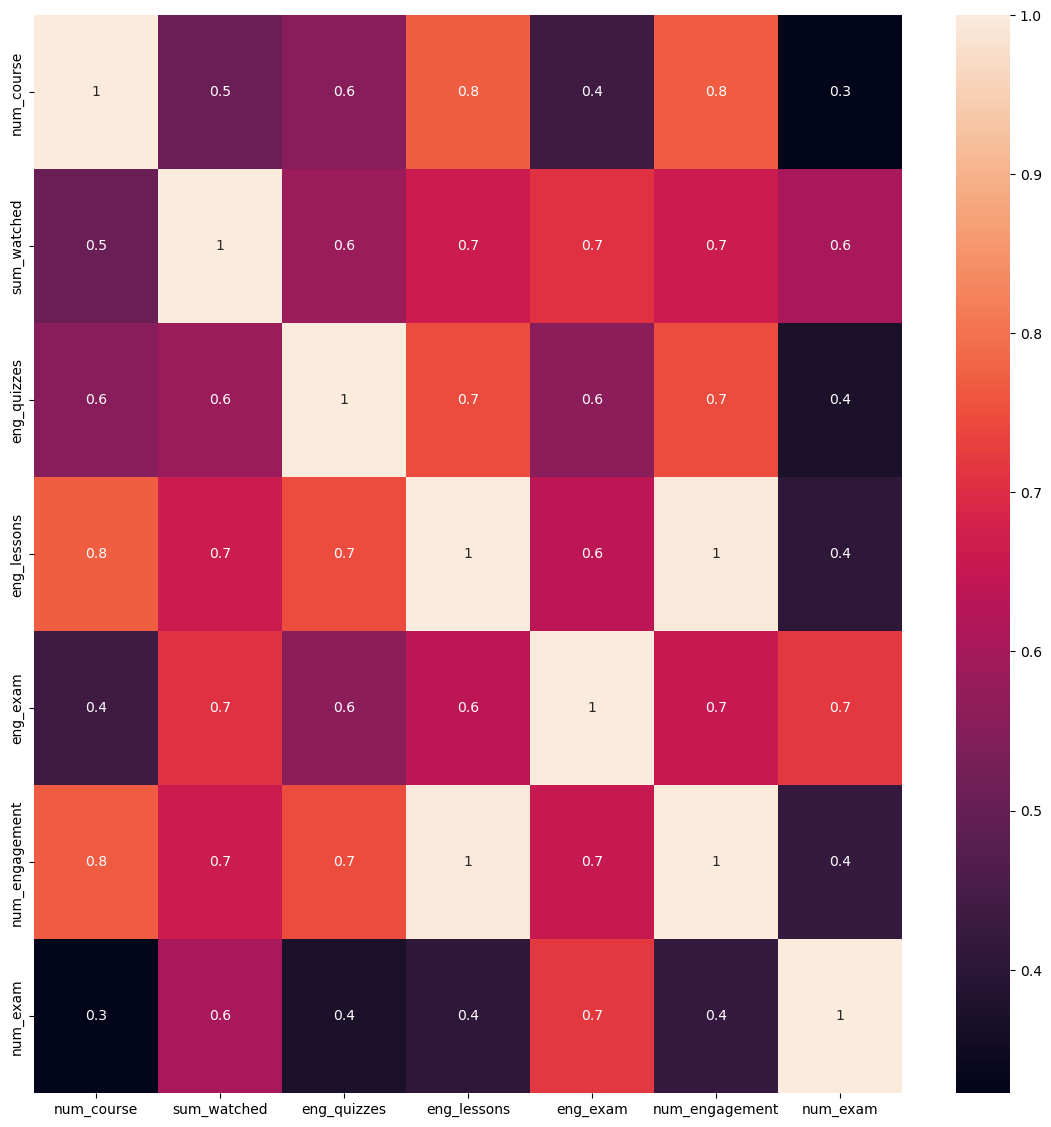

In [12]:
# heatmap으로 컬럼 간의 상관관계 표시
X_features = stuPaid.drop(['student_id', 'class', 'num_qna'], axis=1)
for i in X_features.columns:
    X_features[i] = X_features[i].astype('float')

import seaborn as sns
import matplotlib.pyplot as plt

corr = X_features.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, fmt='.1g')

In [14]:
# PCA / scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_features)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# PCA 결과 데이터프레임
pca_paid = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
pca_paid['student_id'] = stuPaid['student_id'].values
pca_paid['class'] = stuPaid['class'].values
pca_paid

,PCA1,PCA2,student_id,class
0,-0.094942,-0.421565,258798,0
1,-1.085278,0.425670,258799,0
2,-1.085278,0.425670,258800,1
3,-1.085278,0.425670,258801,0
4,-1.085278,0.425670,258802,0
...,...,...,...,...
35225,0.391035,-0.620824,295511,0
35226,0.405274,-0.611256,295512,0
35227,-0.096037,-0.422301,295513,0
35228,-1.085278,0.425670,295514,0


<AxesSubplot: xlabel='PCA1', ylabel='PCA2'>

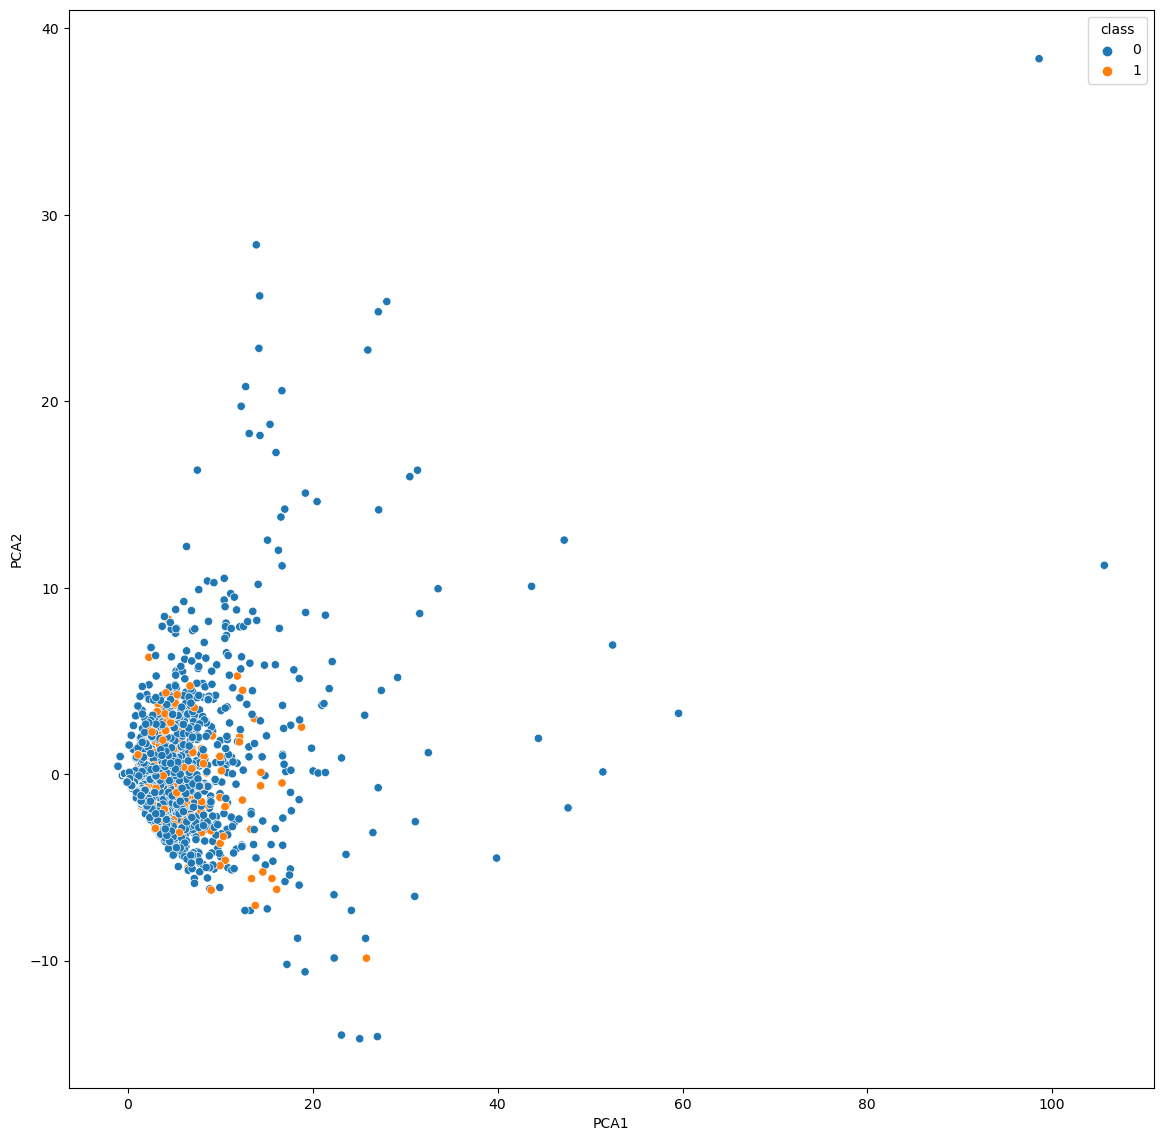

In [15]:
# pca 결과 시각화
plt.figure(figsize=(14,14))
sns.scatterplot(data=pca_paid, x='PCA1', y='PCA2', hue='class')

- 대부분의 무료 학생과 유료 학생이 겹쳐져 있는 모습이 나타남  
    -> 겹쳐져 있는 영역의 무료 학생들은 유료로 전환할 가능성이 높아보임
- 이 중 어떤 무료 학생이 유료로 전환할 가능성이 높은지 계산이 필요

## 변환 확률 계산
- 유료 학생들의 분포를 바탕으로 GMM의 mean, covariance 계산
- mean, covariance를 바탕으로 Gaussian Model 만들고 무료 학생들의 input 데이터에 대한 pdf 계산
- mean에서의 pdf 값 대비 input 데이터 pdf의 비율로 변환 확률 계산
    - mean에 가까울수록 유료학생에 가까운 패턴
    - 따라서 mean에 가까울수록 유료로 전환활 확률 증가

In [16]:
# GMM
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=1)

paiddata = pca_paid[pca_paid['class'] == 1]
X = [[i,j] for i,j in zip(paiddata.PCA1, paiddata.PCA2)]

bgm.fit(X)
display(bgm.means_, bgm.covariances_)

array([[ 1.20300656, -0.01700124]])

array([[[ 5.52865008, -0.26864235],
        [-0.26864235,  1.35882286]]])

In [21]:
# mean, covariance로 normal distribution 계산
mn = multivariate_normal(bgm.means_[0], bgm.covariances_[0])
mn.pdf(bgm.means_[0]) # mean에서의 pdf

# 무료 학생들의 input data & 각각의 pdf
freedata = pca_paid[pca_paid['class'] == 0]
F = [[i,j] for i,j in zip(freedata.PCA1, freedata.PCA2)]
prob = [mn.pdf(i) for i in F]

In [24]:
freedata['prob'] = prob
freedata['prob'] = freedata['prob']
freedata['change_percent'] = freedata['prob'] / (mn.pdf(bgm.means_[0])) * 100
# freedata.sort_values('', ascending=False)
freedata

/tmp/ipykernel_622/3007296204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freedata['prob'] = prob
/tmp/ipykernel_622/3007296204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freedata['prob'] = freedata['prob']
/tmp/ipykernel_622/3007296204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

,PCA1,PCA2,student_id,class,prob,change_percent
0,-0.094942,-0.421565,258798,0,0.046193,79.167420
1,-1.085278,0.425670,258799,0,0.034885,59.787127
3,-1.085278,0.425670,258801,0,0.034885,59.787127
4,-1.085278,0.425670,258802,0,0.034885,59.787127
6,0.426086,-0.597271,258804,0,0.047939,82.160433
...,...,...,...,...,...,...
35225,0.391035,-0.620824,295511,0,0.047137,80.785811
35226,0.405274,-0.611256,295512,0,0.047465,81.348286
35227,-0.096037,-0.422301,295513,0,0.046168,79.125334
35228,-1.085278,0.425670,295514,0,0.034885,59.787127


/home/wony/miniconda3/envs/365/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='PCA1', ylabel='PCA2'>

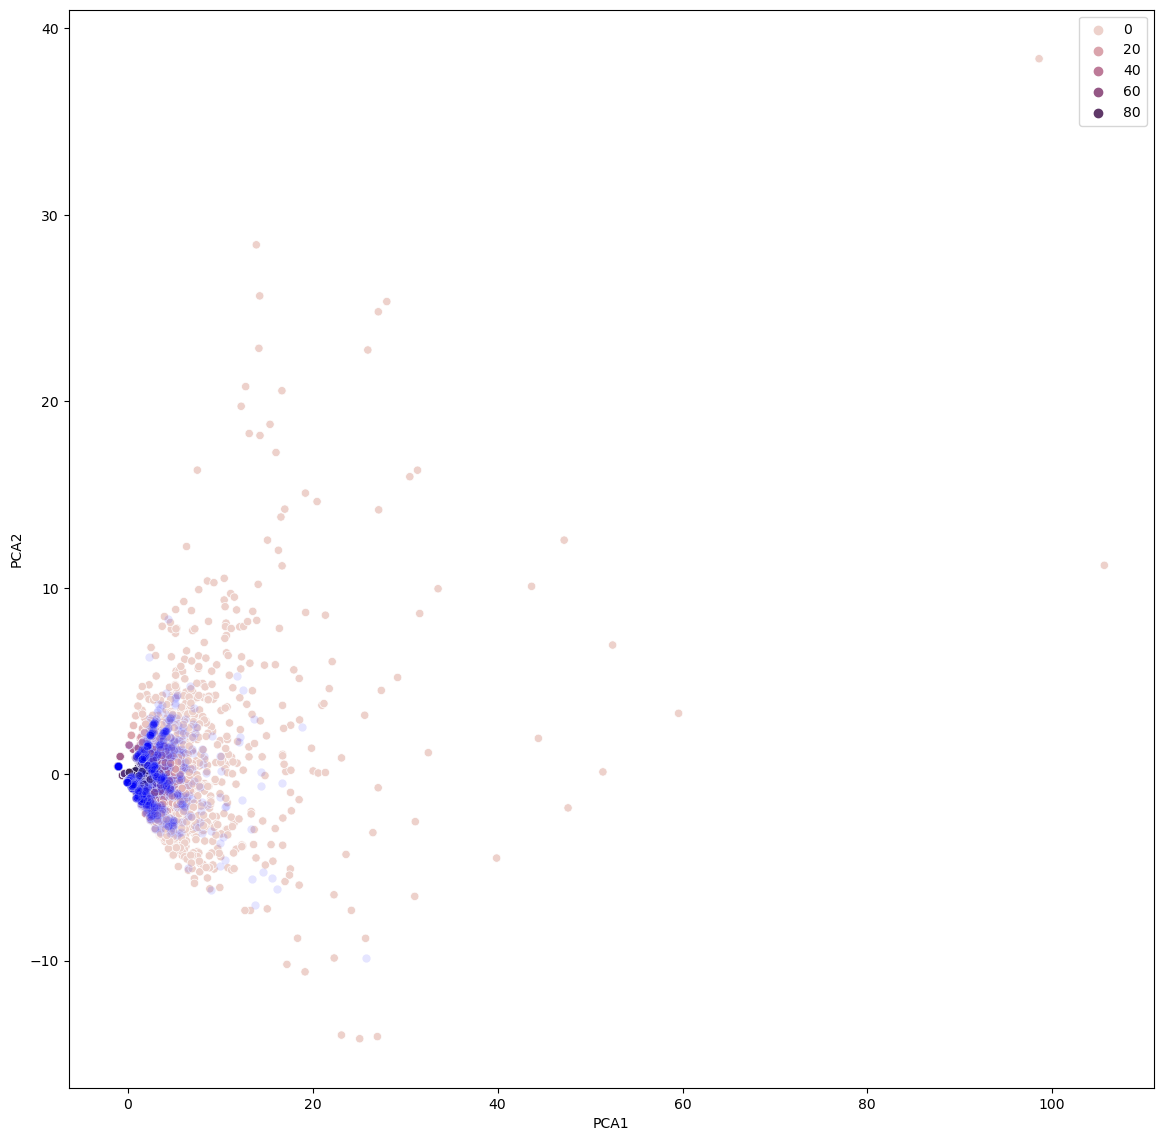

In [25]:
# 결과 시각화
plt.figure(figsize=(14,14))
sns.scatterplot(data=freedata, x='PCA1', y='PCA2', hue='change_percent')
sns.scatterplot(data=paiddata, x='PCA1', y='PCA2', alpha=0.1, color='blue')

- 유료 회원들이 밀집해 있는 지점일수록 무료 학생들의 percent 증가
- 따라서 여기에 일정한 threshold를 지정하면 유료 전환의 목표값이 될 수 있다고 생각

----------------

# 2. 세부 분석